<a href="https://colab.research.google.com/github/alenabozny/context-augmentation/blob/master/LIWC_LR_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mount Google Drive to the Notebook. This allows us to load datasets that are copyied to the GD directory.**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load the dataset (LIWC features for CRED/NONCRED data)**

In [2]:
import pandas as pd
import numpy as np

statins = pd.read_csv("/content/drive/My Drive/Colab Notebooks/LIWC_paragrafy.csv", sep=";",decimal=',', header=0)
psychiatry = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/psychiatry.csv", sep=";",decimal=',', header=0)
antioxidants = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/antioxidants.csv", sep=";",decimal=',', header=0)
ssri_during_pregnancy = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/ssri_during_pregnancy.csv", sep=";",decimal=',', header=0)
cc_vs_nb = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/cc_vs_nb.csv", sep=";",decimal=',', header=0)
aspirin_pregnancy = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/aspirin_pregnancy.csv", sep=";",decimal=',', header=0)
children_antibiotics = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/children_antibiotics.csv", sep=";",decimal=',', header=0)
allergy_testing = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/allergy_testing.csv", sep=";",decimal=',', header=0)
diet_and_autism = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/diet_and_autism.csv", sep=";",decimal=',', header=0)
heart_supplements = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/heart_supplements.csv", sep=";",decimal=',', header=0)
ssri_during_pregnancy = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/ssri_during_pregnancy.csv", sep=";",decimal=',', header=0)
steroids_for_kids = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/steroids_for_kids.csv", sep=";",decimal=',', header=0)
vaccination = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/vaccination.csv", sep=";",decimal=',', header=0)

statins['Body'].head()

0    Statins available in the United States include...
1    Statins are one of the most common medicines p...
2    They work on an enzyme that is used by our bod...
3    Yep, that’s right…our bodies make cholesterol,...
4    That’s because cholesterol is vital for our su...
Name: Body, dtype: object

In [3]:
statins_paragraphs = statins[0:1917:3]
psychiatry_paragraphs = psychiatry[0:len(psychiatry):3]
antioxidants_paragraphs = antioxidants[0:len(antioxidants):3]
ssri_during_pregnancy_paragraphs = ssri_during_pregnancy[0:len(ssri_during_pregnancy):3]
cc_vs_nb_paragraphs = cc_vs_nb[0:len(cc_vs_nb):3]
aspirin_pregnancy_paragraphs = aspirin_pregnancy[0:len(aspirin_pregnancy):3]
children_antibiotics_paragraphs = children_antibiotics[0:len(children_antibiotics):3]
allergy_testing_paragraphs = allergy_testing[0:len(allergy_testing):3]
diet_and_autism_paragraphs = diet_and_autism[0:len(diet_and_autism):3]
heart_supplements_paragraphs = heart_supplements[0:len(heart_supplements):3]
steroids_for_kids_paragraphs = steroids_for_kids[0:len(steroids_for_kids):3]
vaccination_paragraphs = vaccination[0:len(vaccination):3]

In [4]:
ssri_during_pregnancy_paragraphs.head()

,Source (A),Source (B),WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,...,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,There’s a growing and confusing group of studi...,NONCRED,86,98.09,63.65,34.47,1.00,21.50,38.37,94.19,46.51,5.81,0.00,0.0,0.00,0.0,0.0,0.00,5.81,12.79,16.28,3.49,3.49,6.98,1.16,8.14,0.00,0.00,0.00,0.00,2.33,11.63,2.33,9.30,5.81,0.0,2.33,8.14,4.65,0.00,...,4.65,1.16,1.16,9.30,2.33,0.00,2.33,1.16,3.49,1.16,3.49,1.16,11.63,3.49,3.49,4.65,8.14,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,12.79,3.49,2.33,0.0,0.0,0.0,0.0,1.16,0.00,3.49,2.33,0.0
3,"In the latest study to address the subject, re...",NEU,84,96.66,68.29,23.51,1.00,21.00,30.95,83.33,46.43,4.76,1.19,0.0,0.00,0.0,0.0,1.19,3.57,8.33,19.05,8.33,2.38,4.76,2.38,13.10,3.57,3.57,1.19,1.19,3.57,5.95,0.00,5.95,1.19,0.0,4.76,10.71,3.57,1.19,...,1.19,0.00,0.00,5.95,1.19,0.00,1.19,2.38,1.19,13.10,0.00,0.00,10.71,1.19,2.38,5.95,5.95,0.0,1.19,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,16.67,3.57,5.95,0.0,0.0,0.0,0.0,3.57,0.00,1.19,2.38,0.0
6,"In the study, published in JAMA Pediatrics, am...",CRED,106,84.73,68.13,54.63,25.77,26.50,32.08,84.91,43.40,6.60,0.94,0.0,0.00,0.0,0.0,0.94,5.66,5.66,14.15,6.60,1.89,8.49,2.83,10.38,8.49,7.55,2.83,0.00,2.83,8.49,2.83,2.83,0.94,0.0,1.89,12.26,5.66,0.00,...,0.94,0.00,0.00,3.77,0.00,0.94,1.89,0.94,0.00,5.66,3.77,0.94,14.15,0.00,12.26,1.89,4.72,0.0,0.00,0.00,0.0,0.0,0.94,0.0,0.0,0.0,0.94,0.0,14.15,2.83,9.43,0.0,0.0,0.0,0.0,0.94,0.00,0.94,0.00,0.0
9,"Other research showed, for example, that older...",NONCRED,101,94.14,65.41,29.80,12.61,25.25,35.64,79.21,43.56,5.94,0.00,0.0,0.00,0.0,0.0,0.00,5.94,4.95,19.80,3.96,4.95,8.91,0.00,8.91,6.93,4.95,0.99,0.00,0.00,5.94,1.98,2.97,0.99,0.0,0.99,4.95,0.00,0.00,...,0.00,0.00,0.00,1.98,0.00,0.99,0.99,0.00,0.00,5.94,2.97,0.99,15.84,4.95,8.91,1.98,3.96,0.0,0.00,0.00,0.0,0.0,1.98,0.0,0.0,0.0,1.98,0.0,12.87,2.97,7.92,0.0,0.0,0.0,0.0,0.99,0.00,0.99,0.00,0.0
12,Further studies will likely investigate that p...,CRED,49,7.80,58.08,21.80,91.78,12.25,20.41,87.76,55.10,20.41,4.08,0.0,2.04,0.0,0.0,2.04,16.33,6.12,4.08,14.29,8.16,4.08,4.08,24.49,2.04,2.04,4.08,0.00,0.00,4.08,4.08,0.00,0.00,0.0,0.00,6.12,0.00,0.00,...,0.00,0.00,0.00,2.04,2.04,0.00,0.00,0.00,0.00,0.00,16.33,8.16,12.24,2.04,8.16,2.04,4.08,0.0,0.00,2.04,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,22.45,6.12,4.08,0.0,0.0,0.0,0.0,2.04,6.12,4.08,0.00,0.0


In [5]:
def y_to_binary(Y):
  def label_to_0_1(lbl):
    if lbl=='CRED':
      return 1
    else:
      return 0

  Y_mapped = map(label_to_0_1, Y)
  return np.array(list(Y_mapped))

In [6]:
np.shape(ssri_during_pregnancy_paragraphs)

(58, 95)

In [7]:
!pip install spacytextblob

     |████████████████████████████████| 12.8MB 4.3MB/s 
     |████████████████████████████████| 1.1MB 49.5MB/s 
     |████████████████████████████████| 460kB 34.2MB/s 
     |████████████████████████████████| 9.1MB 40.3MB/s 
     |████████████████████████████████| 122kB 49.7MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=966fcc5e44467b435296dad5768326a141f5a421ec757c9e26e7c50382de5be7
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: smart-open 4.2.0
    Uninstallin

# The Model
Features:
- TFIDF
- NER
- POS
- LIWC
- sentiment

In [8]:
from sklearn.pipeline import Pipeline
# from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing as p

def get_y(data, y_column = 'Source (B)'):
  Y = data[y_column]
  Y = y_to_binary(Y)
  print(np.shape(Y))
  return Y

statins_Y = get_y(statins_paragraphs, y_column='Rate')
psychiatry_Y = get_y(psychiatry_paragraphs)
antioxidants_Y = get_y(antioxidants_paragraphs)
cc_vs_nb_Y = get_y(cc_vs_nb_paragraphs)
aspirin_pregnancy_Y = get_y(aspirin_pregnancy_paragraphs)
children_antibiotics_Y = get_y(children_antibiotics_paragraphs)
allergy_testing_Y = get_y(allergy_testing_paragraphs)
diet_and_autism_Y = get_y(diet_and_autism_paragraphs)
heart_supplements_Y = get_y(heart_supplements_paragraphs)
ssri_during_pregnancy_Y = get_y(ssri_during_pregnancy_paragraphs)
steroids_for_kids_Y = get_y(steroids_for_kids_paragraphs)
vaccination_Y = get_y(vaccination_paragraphs)

(639,)
(807,)
(225,)
(171,)
(109,)
(185,)
(451,)
(182,)
(150,)
(58,)
(241,)
(482,)


### **TFIDF**

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk

nltk.download('punkt')

from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize

def get_X_tfidf(data, body_column='Source (A)'):
  corpus = data[body_column]
  corpus_removed_numbers = [re.sub(r'\d+', '', s) for s in corpus]

  corpus_tokenized = []
  stemmer= PorterStemmer()

  for s in corpus_removed_numbers:
    tokens = word_tokenize(s)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    corpus_tokenized.append(" ".join(stemmed_tokens))

  vectorizer = TfidfVectorizer()
  X_tfidf_array = vectorizer.fit_transform(corpus_tokenized)
  X_tfidf_array = np.array(X_tfidf_array.toarray())
  X_tfidf = pd.DataFrame(X_tfidf_array, columns=vectorizer.get_feature_names())
  print(np.shape(X_tfidf))

  return X_tfidf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
statins_X_tfidf = get_X_tfidf(statins_paragraphs, body_column='Body')
psychiatry_X_tfidf = get_X_tfidf(psychiatry_paragraphs)
antioxidants_X_tfidf = get_X_tfidf(antioxidants_paragraphs)
cc_vs_nb_X_tfidf = get_X_tfidf(cc_vs_nb_paragraphs)
aspirin_pregnancy_X_tfidf = get_X_tfidf(aspirin_pregnancy_paragraphs)
children_antibiotics_X_tfidf = get_X_tfidf(children_antibiotics_paragraphs)
allergy_testing_X_tfidf = get_X_tfidf(allergy_testing_paragraphs)
diet_and_autism_X_tfidf = get_X_tfidf(diet_and_autism_paragraphs)
heart_supplements_X_tfidf = get_X_tfidf(heart_supplements_paragraphs)
ssri_during_pregnancy_X_tfidf = get_X_tfidf(ssri_during_pregnancy_paragraphs)
steroids_for_kids_X_tfidf = get_X_tfidf(steroids_for_kids_paragraphs)
vaccination_X_tfidf = get_X_tfidf(vaccination_paragraphs)

(639, 3352)
(807, 4013)
(225, 1565)
(171, 1511)
(109, 1219)
(185, 1567)
(451, 2231)
(182, 1695)
(150, 1431)
(58, 889)
(241, 1407)
(482, 2742)


In [32]:
ssri_during_pregnancy_X_tfidf.head()

,aa,abil,abnorm,about,absolut,abus,access,accompani,accord,accordingli,account,accumul,acid,acrocynaosi,across,act,acupunctur,ad,adapt,add,address,adjust,administ,admiss,admit,adolesc,adult,advers,advis,ae,affect,after,against,age,aj,al,all,alon,alprazolam,also,...,we,weak,weigh,weight,weissman,well,were,weren,werler,what,when,where,whether,whi,which,while,white,whitelaw,who,whose,will,wind,with,withdraw,within,without,woman,womb,women,work,worri,worth,would,year,yoga,york,you,your,zero,zoloft
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.111466,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.203414,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.103277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.092423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146028,0.0,0.0,0.146028,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.104303,0.099856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076769,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.418425,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.099856,0.0,0.0,0.086351,0.000000,0.000000,0.0,0.101397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.077617,0.210835,0.0,0.0,0.091905,0.0,0.0,0.0,0.0,0.000000,0.083858,0.0,0.0,0.000000,0.175187,0.000000,0.0,0.042576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.122302,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.122302,0.0,0.0,0.0,0.087356,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064296,...,0.000000,0.0,0.000000,0.0,0.0,0.154814,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.091656,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.042461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.129985,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.142457,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.150362,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##**NER**

In [11]:
!python -m spacy download en_core_web_sm

2021-04-08 11:30:36.083965: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.7MB 296kB/s 
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [12]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

nlp = spacy.load("en_core_web_sm")

def get_X_ner(data, body_column='Source (A)'):
  corpus = data[body_column]
  X_ner_counters = []
  X_ner_array = []
  meta_counter = Counter()

  for s in corpus:
    doc = nlp(s)
    labels = [x.label_ for x in doc.ents]
    X_ner_counters.append(Counter(labels))
    meta_counter += Counter(labels)

  for c in X_ner_counters:
    X_ner_array.append([c[key] for key in list(meta_counter.keys())])

  X_ner = pd.DataFrame(X_ner_array, columns=list(meta_counter.keys()))
  print(np.shape(X_ner))
  
  return X_ner

In [13]:
statins_X_ner = get_X_ner(statins_paragraphs, body_column='Body')
psychiatry_X_ner = get_X_ner(psychiatry_paragraphs)
antioxidants_X_ner = get_X_ner(antioxidants_paragraphs)
cc_vs_nb_X_ner = get_X_ner(cc_vs_nb_paragraphs)
aspirin_pregnancy_X_ner = get_X_ner(aspirin_pregnancy_paragraphs)
children_antibiotics_X_ner = get_X_ner(children_antibiotics_paragraphs)
allergy_testing_X_ner = get_X_ner(allergy_testing_paragraphs)
diet_and_autism_X_ner = get_X_ner(diet_and_autism_paragraphs)
heart_supplements_X_ner = get_X_ner(heart_supplements_paragraphs)
ssri_during_pregnancy_X_ner = get_X_ner(ssri_during_pregnancy_paragraphs)
steroids_for_kids_X_ner = get_X_ner(steroids_for_kids_paragraphs)
vaccination_X_ner = get_X_ner(vaccination_paragraphs)

(639, 17)
(807, 18)
(225, 12)
(171, 13)
(109, 13)
(185, 14)
(451, 16)
(182, 12)
(150, 14)
(58, 13)
(241, 13)
(482, 17)


## **LIWC**

In [14]:
# important_features = get_n_most_important(50)
def get_X_liwc(data):
  X_liwc = data.loc[:,'WC':]
  X_liwc = X_liwc.reset_index(drop=True)
  print(np.shape(X_liwc))
  
  return X_liwc

In [15]:
statins_X_liwc = get_X_liwc(statins_paragraphs)
psychiatry_X_liwc = get_X_liwc(psychiatry_paragraphs)
antioxidants_X_liwc = get_X_liwc(antioxidants_paragraphs)
cc_vs_nb_X_liwc = get_X_liwc(cc_vs_nb_paragraphs)
aspirin_pregnancy_X_liwc = get_X_liwc(aspirin_pregnancy_paragraphs)
children_antibiotics_X_liwc = get_X_liwc(children_antibiotics_paragraphs)
allergy_testing_X_liwc = get_X_liwc(allergy_testing_paragraphs)
diet_and_autism_X_liwc = get_X_liwc(diet_and_autism_paragraphs)
heart_supplements_X_liwc = get_X_liwc(heart_supplements_paragraphs)
ssri_during_pregnancy_X_liwc = get_X_liwc(ssri_during_pregnancy_paragraphs)
steroids_for_kids_X_liwc = get_X_liwc(steroids_for_kids_paragraphs)
vaccination_X_liwc = get_X_liwc(vaccination_paragraphs)

(639, 93)
(807, 93)
(225, 93)
(171, 93)
(109, 93)
(185, 93)
(451, 93)
(182, 93)
(150, 93)
(58, 93)
(241, 93)
(482, 93)


In [16]:
ssri_during_pregnancy_X_liwc.head()

,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,...,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,86,98.09,63.65,34.47,1.00,21.50,38.37,94.19,46.51,5.81,0.00,0.0,0.00,0.0,0.0,0.00,5.81,12.79,16.28,3.49,3.49,6.98,1.16,8.14,0.00,0.00,0.00,0.00,2.33,11.63,2.33,9.30,5.81,0.0,2.33,8.14,4.65,0.00,2.33,0.00,...,4.65,1.16,1.16,9.30,2.33,0.00,2.33,1.16,3.49,1.16,3.49,1.16,11.63,3.49,3.49,4.65,8.14,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,12.79,3.49,2.33,0.0,0.0,0.0,0.0,1.16,0.00,3.49,2.33,0.0
1,84,96.66,68.29,23.51,1.00,21.00,30.95,83.33,46.43,4.76,1.19,0.0,0.00,0.0,0.0,1.19,3.57,8.33,19.05,8.33,2.38,4.76,2.38,13.10,3.57,3.57,1.19,1.19,3.57,5.95,0.00,5.95,1.19,0.0,4.76,10.71,3.57,1.19,2.38,1.19,...,1.19,0.00,0.00,5.95,1.19,0.00,1.19,2.38,1.19,13.10,0.00,0.00,10.71,1.19,2.38,5.95,5.95,0.0,1.19,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,16.67,3.57,5.95,0.0,0.0,0.0,0.0,3.57,0.00,1.19,2.38,0.0
2,106,84.73,68.13,54.63,25.77,26.50,32.08,84.91,43.40,6.60,0.94,0.0,0.00,0.0,0.0,0.94,5.66,5.66,14.15,6.60,1.89,8.49,2.83,10.38,8.49,7.55,2.83,0.00,2.83,8.49,2.83,2.83,0.94,0.0,1.89,12.26,5.66,0.00,2.83,0.00,...,0.94,0.00,0.00,3.77,0.00,0.94,1.89,0.94,0.00,5.66,3.77,0.94,14.15,0.00,12.26,1.89,4.72,0.0,0.00,0.00,0.0,0.0,0.94,0.0,0.0,0.0,0.94,0.0,14.15,2.83,9.43,0.0,0.0,0.0,0.0,0.94,0.00,0.94,0.00,0.0
3,101,94.14,65.41,29.80,12.61,25.25,35.64,79.21,43.56,5.94,0.00,0.0,0.00,0.0,0.0,0.00,5.94,4.95,19.80,3.96,4.95,8.91,0.00,8.91,6.93,4.95,0.99,0.00,0.00,5.94,1.98,2.97,0.99,0.0,0.99,4.95,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.98,0.00,0.99,0.99,0.00,0.00,5.94,2.97,0.99,15.84,4.95,8.91,1.98,3.96,0.0,0.00,0.00,0.0,0.0,1.98,0.0,0.0,0.0,1.98,0.0,12.87,2.97,7.92,0.0,0.0,0.0,0.0,0.99,0.00,0.99,0.00,0.0
4,49,7.80,58.08,21.80,91.78,12.25,20.41,87.76,55.10,20.41,4.08,0.0,2.04,0.0,0.0,2.04,16.33,6.12,4.08,14.29,8.16,4.08,4.08,24.49,2.04,2.04,4.08,0.00,0.00,4.08,4.08,0.00,0.00,0.0,0.00,6.12,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,2.04,2.04,0.00,0.00,0.00,0.00,0.00,16.33,8.16,12.24,2.04,8.16,2.04,4.08,0.0,0.00,2.04,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,22.45,6.12,4.08,0.0,0.0,0.0,0.0,2.04,6.12,4.08,0.00,0.0


## **Sentiment**

In [17]:
from spacytextblob.spacytextblob import SpacyTextBlob

nlp.add_pipe('spacytextblob')

In [18]:
def get_X_sentiment(data, body_column='Source (A)'):
  corpus = data[body_column]
  X_sentiment_array = []
  for s in corpus:
    doc = nlp(s)
    X_sentiment_array.append([doc._.polarity,
                              doc._.subjectivity]
                            )
    
  X_sentiment = pd.DataFrame(X_sentiment_array, columns=["polarity", "subjectivity"])
  print(np.shape(X_sentiment))
  
  return X_sentiment

In [19]:
statins_X_sentiment = get_X_sentiment(statins_paragraphs, body_column='Body')
psychiatry_X_sentiment = get_X_sentiment(psychiatry_paragraphs)
antioxidants_X_sentiment = get_X_sentiment(antioxidants_paragraphs)
cc_vs_nb_X_sentiment = get_X_sentiment(cc_vs_nb_paragraphs)
aspirin_pregnancy_X_sentiment = get_X_sentiment(aspirin_pregnancy_paragraphs)
children_antibiotics_X_sentiment = get_X_sentiment(children_antibiotics_paragraphs)
allergy_testing_X_sentiment = get_X_sentiment(allergy_testing_paragraphs)
diet_and_autism_X_sentiment = get_X_sentiment(diet_and_autism_paragraphs)
heart_supplements_X_sentiment = get_X_sentiment(heart_supplements_paragraphs)
ssri_during_pregnancy_X_sentiment = get_X_sentiment(ssri_during_pregnancy_paragraphs)
steroids_for_kids_X_sentiment = get_X_sentiment(steroids_for_kids_paragraphs)
vaccination_X_sentiment = get_X_sentiment(vaccination_paragraphs)

(639, 2)
(807, 2)
(225, 2)
(171, 2)
(109, 2)
(185, 2)
(451, 2)
(182, 2)
(150, 2)
(58, 2)
(241, 2)
(482, 2)


In [20]:
# X = pd.concat([X_liwc, X_ner, X_tfidf, X_sentiment], axis=1)
statins_X = pd.concat([statins_X_liwc, statins_X_ner, statins_X_tfidf, statins_X_sentiment], axis=1)
psychiatry_X = pd.concat([psychiatry_X_liwc, psychiatry_X_ner, psychiatry_X_tfidf, psychiatry_X_sentiment], axis=1)
antioxidants_X = pd.concat([antioxidants_X_liwc, antioxidants_X_ner, antioxidants_X_tfidf, antioxidants_X_sentiment], axis=1)
cc_vs_nb_X = pd.concat([cc_vs_nb_X_liwc, cc_vs_nb_X_ner, cc_vs_nb_X_tfidf, cc_vs_nb_X_sentiment], axis=1)
aspirin_pregnancy_X = pd.concat([aspirin_pregnancy_X_liwc, aspirin_pregnancy_X_ner, aspirin_pregnancy_X_tfidf, aspirin_pregnancy_X_sentiment], axis=1)
children_antibiotics_X = pd.concat([children_antibiotics_X_liwc, children_antibiotics_X_ner, children_antibiotics_X_tfidf, children_antibiotics_X_sentiment], axis=1)
allergy_testing_X = pd.concat([allergy_testing_X_liwc, allergy_testing_X_ner, allergy_testing_X_tfidf, allergy_testing_X_sentiment], axis=1)
diet_and_autism_X = pd.concat([diet_and_autism_X_liwc, diet_and_autism_X_ner, diet_and_autism_X_tfidf, diet_and_autism_X_sentiment], axis=1)
heart_supplements_X = pd.concat([heart_supplements_X_liwc, heart_supplements_X_ner, heart_supplements_X_tfidf, heart_supplements_X_sentiment], axis=1)
ssri_during_pregnancy_X = pd.concat([ssri_during_pregnancy_X_liwc, ssri_during_pregnancy_X_ner, ssri_during_pregnancy_X_tfidf, ssri_during_pregnancy_X_sentiment], axis=1)
steroids_for_kids_X = pd.concat([steroids_for_kids_X_liwc, steroids_for_kids_X_ner, steroids_for_kids_X_tfidf, steroids_for_kids_X_sentiment], axis=1)
vaccination_X = pd.concat([vaccination_X_liwc, vaccination_X_ner, vaccination_X_tfidf, vaccination_X_sentiment], axis=1)

In [21]:
ssri_during_pregnancy_X

,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,...,weigh,weight,weissman,well,were,weren,werler,what,when,where,whether,whi,which,while,white,whitelaw,who,whose,will,wind,with,withdraw,within,without,woman,womb,women,work,worri,worth,would,year,yoga,york,you,your,zero,zoloft,polarity,subjectivity
0,86,98.09,63.65,34.47,1.00,21.50,38.37,94.19,46.51,5.81,0.00,0.00,0.00,0.00,0.00,0.00,5.81,12.79,16.28,3.49,3.49,6.98,1.16,8.14,0.00,0.00,0.00,0.00,2.33,11.63,2.33,9.30,5.81,0.00,2.33,8.14,4.65,0.00,2.33,0.00,...,0.111466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000e-01,0.525000
1,84,96.66,68.29,23.51,1.00,21.00,30.95,83.33,46.43,4.76,1.19,0.00,0.00,0.00,0.00,1.19,3.57,8.33,19.05,8.33,2.38,4.76,2.38,13.10,3.57,3.57,1.19,1.19,3.57,5.95,0.00,5.95,1.19,0.00,4.76,10.71,3.57,1.19,2.38,1.19,...,0.000000,0.000000,0.000000,0.000000,0.418425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099856,0.000000,0.000000,0.086351,0.000000,0.000000,0.000000,0.101397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667e-01,0.616667
2,106,84.73,68.13,54.63,25.77,26.50,32.08,84.91,43.40,6.60,0.94,0.00,0.00,0.00,0.00,0.94,5.66,5.66,14.15,6.60,1.89,8.49,2.83,10.38,8.49,7.55,2.83,0.00,2.83,8.49,2.83,2.83,0.94,0.00,1.89,12.26,5.66,0.00,2.83,0.00,...,0.000000,0.000000,0.000000,0.077617,0.210835,0.000000,0.000000,0.091905,0.000000,0.000000,0.000000,0.000000,0.000000,0.083858,0.000000,0.000000,0.000000,0.175187,0.000000,0.000000,0.042576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.805556e-01,0.425000
3,101,94.14,65.41,29.80,12.61,25.25,35.64,79.21,43.56,5.94,0.00,0.00,0.00,0.00,0.00,0.00,5.94,4.95,19.80,3.96,4.95,8.91,0.00,8.91,6.93,4.95,0.99,0.00,0.00,5.94,1.98,2.97,0.99,0.00,0.99,4.95,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.154814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.500000e-02,0.432143
4,49,7.80,58.08,21.80,91.78,12.25,20.41,87.76,55.10,20.41,4.08,0.00,2.04,0.00,0.00,2.04,16.33,6.12,4.08,14.29,8.16,4.08,4.08,24.49,2.04,2.04,4.08,0.00,0.00,4.08,4.08,0.00,0.00,0.00,0.00,6.12,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.250000e-02,0.491667
5,62,84.99,98.16,20.84,1.00,15.50,41.94,82.26,29.03,6.45,3.23,0.00,0.00,0.00,0.00,3.23,3.23,1.61,12.90,3.23,3.23,6.45,1.61,11.29,3.23,1.61,4.84,4.84,0.00,6.45,0.00,6.45,1.61,0.00,4.84,25.81,12.90,0.00,6.45,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.276182,0.000000,0.000000,0.000000,0.000000,0.000000,0.193332,0.000000,0.000000,0.096444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.250000e-01,0.500000
6,115,91.49,80.77,22.78,2.58

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

import sklearn.preprocessing as p

min_max_scaler = p.MinMaxScaler()
standard_scaler = p.StandardScaler()

class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def eval_and_print_metrics(clf, X, Y, VALIDATION_SPLIT):
    scaled_features = standard_scaler.fit_transform(X)
    scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VALIDATION_SPLIT, stratify=Y)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print("F1 score on test set: "
          # "%0.3f" % metrics.f1_score(y_test, y_pred, average='weighted'))
    # print("-" * 10)
    return metrics.f1_score(y_test, y_pred, average='weighted'), metrics.f1_score(y_test, y_pred, average='micro')

def mean_weighted_f1(clf, X, Y, num_iterations, VALIDATION_SPLIT):
  f1s_w = []
  f1s_m = []
  for i in range(0,num_iterations):
    w, m = eval_and_print_metrics(clf, X, Y, VALIDATION_SPLIT)
    f1s_w.append(w)
    f1s_m.append(m)

  print(color.BOLD + 'Mean weighted f1: ' + color.END, np.mean(f1s_w), color.BOLD + ' STD: ' + color.END, np.std(f1s_w))
  print(color.BOLD + 'Mean micro f1: ' + color.END , np.mean(f1s_m), color.BOLD + ' STD: ' + color.END, np.std(f1s_m))

# Fit and show AUC

##**RFE**

In [46]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

def get_n_most_important(num_features, X, Y, standarize=True, scorer='roc_auc', model = LogisticRegression(max_iter=10000)):
  if standarize:
    scaled_features = standard_scaler.fit_transform(X)
    X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

  rfecv = RFECV(estimator=model, step=10, cv=StratifiedKFold(),
                scoring=scorer,
                min_features_to_select=num_features)
  fit = rfecv.fit(X, Y)

  print("Optimal number of features : %d" % rfecv.n_features_)

  # Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(num_features,
                len(rfecv.grid_scores_) + num_features),
          rfecv.grid_scores_)
  plt.show()

  features = X.columns.values
  important_features = []

  for f in list(zip(features, fit.support_)):
    if f[1]:
      important_features.append(f[0])

  return fit.support_, fit.n_features_, fit.ranking_, important_features

##**Fit method**

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def fit_clf_and_show_ROC(clf, X, Y, category = 'statins', num_important_features=None, 
                         VALIDATION_SPLIT=0.2, standarize=True):
  if not num_important_features:
    important_features = X.columns.values
  else:
    sup, n_ftrs, rank, important_features = get_n_most_important(num_important_features, X, Y)
  
  print("Number of features: ", str(len(important_features)))
  print(important_features)

  X = X[important_features]
  scaled_features = standard_scaler.fit_transform(X)
  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VALIDATION_SPLIT, stratify=Y)
  clf.fit(X_train, y_train)

  clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Positive class classification (area = %0.2f)' % clf_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for category: ' + category + '; classifier: ' + clf.__class__.__name__ )
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  from sklearn.metrics import classification_report
  
  print(classification_report(y_test, clf.predict(X_test)))
  return sup, n_ftrs, rank, important_features

# **TPOT model selection**

In [ ]:
!pip install deap update_checker tqdm stopit xgboost

In [ ]:
!pip install tpot

In [30]:
from tpot import TPOTClassifier
from tpot.config import classifier_config_dict
import random as r

In [67]:
tpot_config = {
    'sklearn.linear_model.LogisticRegression': {
        'class_weight': [None, 'balanced'],
        'max_iter': [10000]
    },

    'sklearn.neural_network.MLPClassifier': {
        'hidden_layer_sizes': [(50, 20), (30,20)],
        'activation': ['relu', 'logistic'],
        'learning_rate': ['adaptive'],
        'max_iter': [1000]
    },

    'sklearn.ensemble.GradientBoostingClassifier': {
    }
}

def teapot_optimizer(X, Y, num_important_features, random=False, tpot_config=tpot_config, 
                     cv=10, VALIDATION_SPLIT=0.2, category='undefined', scoring='roc_auc',
                     standarize=True):
  
  if random:
    print("Choosing random features...")
    important_features = random.sample(list(X.columns.values), num_important_features)
  else:
    print("Running RFE to find the most supportive features")
    _,_,_,important_features = get_n_most_important(num_important_features, X, Y, standarize=standarize)

  print("Number of features: ", str(len(important_features)))
  print(important_features)

  X = X[important_features]

  if standarize:
    scaled_features = standard_scaler.fit_transform(X)
    X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VALIDATION_SPLIT, stratify=Y)

  tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, 
                        scoring=scoring, cv=cv, subsample=VALIDATION_SPLIT,
                        config_dict=tpot_config)
  tpot.fit(X_train, y_train)

  clf_roc_auc = roc_auc_score(y_test, tpot.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, tpot.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Positive class classification (area = %0.2f)' % clf_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for category: ' + category + '; classifier: ' + tpot.__class__.__name__ )
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  from sklearn.metrics import classification_report
  
  print(classification_report(y_test, tpot.predict(X_test)))

  return important_features, tpot
  # tpot.export('tpot_digits_pipeline_antioxidants.py')

In [32]:
import pickle

#For each category we are preforming the following steps:
1. **Feature selection** based on **LogisticRegression** and **Recursive Feature Elimination** algorithm
2. Perform **best model selection** based on genetic algorithm implemented by the TPOT library (we combine LogisticRegression, GBoost, MLP(50,20) and MLP(20,20). We use **weighted f1** measure as **optimization attribute**.
3. **ROC curve** is shown for the **result of TPOT best fitted model**
4. **Mean weighted f1 for 30 Cross Validated scores** with standard deviation is shown. 



## vaccines

In [65]:
np.shape(vaccination_X)

(482, 2854)

Running RFE to find the most supportive features
Optimal number of features : 814


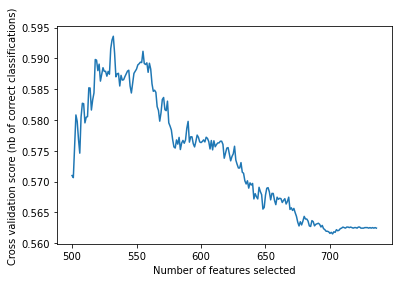

Number of features:  814
['WC', 'WPS', 'Sixltr', 'ipron', 'adverb', 'conj', 'interrog', 'anx', 'social', 'insight', 'cause', 'tentat', 'differ', 'body', 'health', 'drives', 'reward', 'risk', 'leisure', 'money', 'death', 'nonflu', 'Comma', 'CARDINAL', 'ORDINAL', 'NORP', 'MONEY', 'aabi', 'abort', 'abroad', 'abstract', 'academi', 'accord', 'accordingli', 'account', 'achiev', 'add', 'addit', 'adhd', 'administr', 'adult', 'advis', 'affirm', 'afghanistan', 'after', 'ag', 'against', 'age', 'ago', 'ailment', 'all', 'alleg', 'allerg', 'allow', 'amount', 'amput', 'an', 'analysi', 'analyz', 'and', 'anim', 'annual', 'anoth', 'antibiot', 'antigen', 'anybodi', 'anyon', 'appli', 'are', 'aren', 'argument', 'arm', 'articl', 'as', 'ask', 'attempt', 'attenu', 'autism', 'autoimmun', 'away', 'background', 'bacteria', 'bandim', 'base', 'be', 'bear', 'becaus', 'began', 'begin', 'belief', 'best', 'beyond', 'bias', 'bill', 'billion', 'birth', 'birthweight', 'blatant', 'blind', 'bloomberg', 'bodi', 'body', 'boi


Generation 1 - Current best internal CV score: 0.8645833333333334

Generation 2 - Current best internal CV score: 0.8645833333333334

Generation 3 - Current best internal CV score: 0.8645833333333334

Generation 4 - Current best internal CV score: 0.8895833333333334

Generation 5 - Current best internal CV score: 0.8895833333333334

Best pipeline: MLPClassifier(MLPClassifier(input_matrix, activation=logistic, hidden_layer_sizes=(50, 20), learning_rate=adaptive, max_iter=1000), activation=relu, hidden_layer_sizes=(30, 20), learning_rate=adaptive, max_iter=1000)


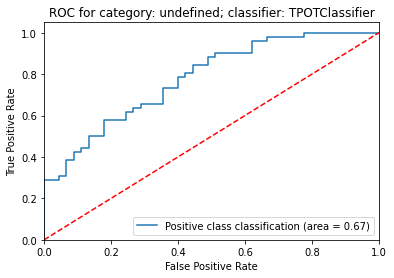

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        45
           1       0.69      0.69      0.69        52

    accuracy                           0.67        97
   macro avg       0.67      0.67      0.67        97
weighted avg       0.67      0.67      0.67        97



In [68]:
vac_important_features, tpot_vac = teapot_optimizer(vaccination_X, 
                             vaccination_Y,
                             num_important_features = 500,
                            standarize=True)
pickle.dump(tpot_vac.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/vac_fitted_pipeline.p','wb'))

In [69]:
vac_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/vac_fitted_pipeline.p','rb'))

In [71]:
mean_weighted_f1(vac_pipeline, vaccination_X[vac_important_features], vaccination_Y, 30, 0.2)

Mean weighted f1:  0.8464763657241606  STD:  0.031350865937430486
Mean micro f1:  0.8470790378006874  STD:  0.031165562108620364


In [75]:
vac_important_features

['WC',
 'WPS',
 'Sixltr',
 'ipron',
 'adverb',
 'conj',
 'interrog',
 'anx',
 'social',
 'insight',
 'cause',
 'tentat',
 'differ',
 'body',
 'health',
 'drives',
 'reward',
 'risk',
 'leisure',
 'money',
 'death',
 'nonflu',
 'Comma',
 'CARDINAL',
 'ORDINAL',
 'NORP',
 'MONEY',
 'aabi',
 'abort',
 'abroad',
 'abstract',
 'academi',
 'accord',
 'accordingli',
 'account',
 'achiev',
 'add',
 'addit',
 'adhd',
 'administr',
 'adult',
 'advis',
 'affirm',
 'afghanistan',
 'after',
 'ag',
 'against',
 'age',
 'ago',
 'ailment',
 'all',
 'alleg',
 'allerg',
 'allow',
 'amount',
 'amput',
 'an',
 'analysi',
 'analyz',
 'and',
 'anim',
 'annual',
 'anoth',
 'antibiot',
 'antigen',
 'anybodi',
 'anyon',
 'appli',
 'are',
 'aren',
 'argument',
 'arm',
 'articl',
 'as',
 'ask',
 'attempt',
 'attenu',
 'autism',
 'autoimmun',
 'away',
 'background',
 'bacteria',
 'bandim',
 'base',
 'be',
 'bear',
 'becaus',
 'began',
 'begin',
 'belief',
 'best',
 'beyond',
 'bias',
 'bill',
 'billion',
 'birth'

## statins

Running RFE to find the most supportive features
Optimal number of features : 1264


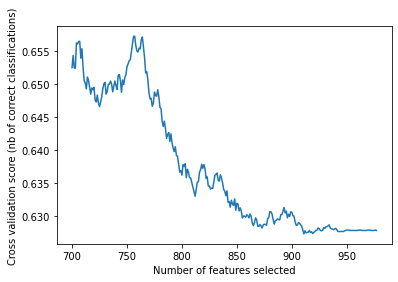

Number of features:  1264
['Analytic', 'Authentic', 'Dic', 'function', 'pronoun', 'ppron', 'we', 'shehe', 'ipron', 'adverb', 'negate', 'verb', 'interrog', 'number', 'affect', 'posemo', 'negemo', 'sad', 'social', 'friend', 'cogproc', 'insight', 'cause', 'tentat', 'bio', 'health', 'ingest', 'affiliation', 'power', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'space', 'money', 'death', 'assent', 'Period', 'Comma', 'QMark', 'Dash', 'Apostro', 'GPE', 'ORG', 'DATE', 'LOC', 'TIME', 'WORK_OF_ART', 'LANGUAGE', 'aberr', 'abil', 'abl', 'abnorm', 'abov', 'absolut', 'abstract', 'academ', 'academi', 'accept', 'access', 'accomplish', 'accur', 'accus', 'ach', 'acid', 'acids', 'across', 'action', 'activ', 'actual', 'ad', 'adequ', 'administr', 'adren', 'advanc', 'advis', 'afford', 'ag', 'again', 'age', 'agre', 'aim', 'al', 'albacor', 'alcohol', 'almond', 'alon', 'along', 'alreadi', 'also', 'alway', 'amanda', 'america', 'among', 'amount', 'an', 'analys', 'analyz', 'anecdot', 'angiogram', 'angri


Generation 1 - Current best internal CV score: 0.8644999999999999

Generation 2 - Current best internal CV score: 0.8644999999999999

Generation 3 - Current best internal CV score: 0.8711666666666668

Generation 4 - Current best internal CV score: 0.8711666666666668

Generation 5 - Current best internal CV score: 0.8711666666666668

Best pipeline: LogisticRegression(MLPClassifier(GradientBoostingClassifier(input_matrix), activation=logistic, hidden_layer_sizes=(30, 20), learning_rate=adaptive, max_iter=1000), class_weight=balanced, max_iter=10000)


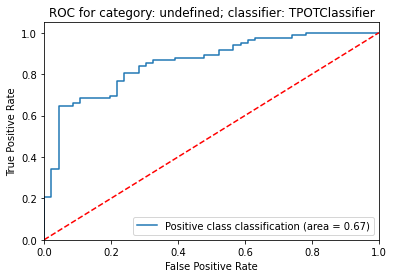

              precision    recall  f1-score   support

           0       0.89      0.37      0.52        46
           1       0.73      0.98      0.84        82

    accuracy                           0.76       128
   macro avg       0.81      0.67      0.68       128
weighted avg       0.79      0.76      0.72       128



In [72]:
stat_important_features, tpot_stat = teapot_optimizer(statins_X, 
                             statins_Y,
                             num_important_features = 700)
pickle.dump(tpot_stat.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/stat_fitted_pipeline.p','wb'))

In [73]:
stat_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/stat_fitted_pipeline.p','rb'))

In [74]:
mean_weighted_f1(stat_pipeline, statins_X[stat_important_features], statins_Y, 30, 0.2)

Mean weighted f1:  0.7507730870141908  STD:  0.03347588083470196
Mean micro f1:  0.7609375  STD:  0.031353993631859194


In [76]:
stat_important_features

['Analytic',
 'Authentic',
 'Dic',
 'function',
 'pronoun',
 'ppron',
 'we',
 'shehe',
 'ipron',
 'adverb',
 'negate',
 'verb',
 'interrog',
 'number',
 'affect',
 'posemo',
 'negemo',
 'sad',
 'social',
 'friend',
 'cogproc',
 'insight',
 'cause',
 'tentat',
 'bio',
 'health',
 'ingest',
 'affiliation',
 'power',
 'focuspast',
 'focuspresent',
 'focusfuture',
 'relativ',
 'space',
 'money',
 'death',
 'assent',
 'Period',
 'Comma',
 'QMark',
 'Dash',
 'Apostro',
 'GPE',
 'ORG',
 'DATE',
 'LOC',
 'TIME',
 'WORK_OF_ART',
 'LANGUAGE',
 'aberr',
 'abil',
 'abl',
 'abnorm',
 'abov',
 'absolut',
 'abstract',
 'academ',
 'academi',
 'accept',
 'access',
 'accomplish',
 'accur',
 'accus',
 'ach',
 'acid',
 'acids',
 'across',
 'action',
 'activ',
 'actual',
 'ad',
 'adequ',
 'administr',
 'adren',
 'advanc',
 'advis',
 'afford',
 'ag',
 'again',
 'age',
 'agre',
 'aim',
 'al',
 'albacor',
 'alcohol',
 'almond',
 'alon',
 'along',
 'alreadi',
 'also',
 'alway',
 'amanda',
 'america',
 'among',

## ssri_during_pregnancy

In [ ]:
ssri_important_features, tpot_ssri = teapot_optimizer(ssri_during_pregnancy_X, 
                             ssri_during_pregnancy_Y,
                             num_important_features = 50, 
                             cv=5,
                             VALIDATION_SPLIT=0.4)
pickle.dump(tpot_ssri.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/ssri_fitted_pipeline.p','wb'))

In [40]:
ssri_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/ssri_fitted_pipeline.p','rb'))
mean_weighted_f1(ssri_pipeline, ssri_during_pregnancy_X[ssri_important_features], ssri_during_pregnancy_Y, 20, 0.3)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean weighted f1:  0.6395328700950891  STD:  0.08000980120999246
Mean micro f1:  0.6722222222222223  STD:  0.06060395619242062


## antioxidants

In [ ]:
np.shape(antioxidants_X)

In [ ]:
antioxidants_important_features, tpot_antiox = teapot_optimizer(antioxidants_X, 
                               antioxidants_Y, 
                               num_important_features = 200,
                               VALIDATION_SPLIT=0.3)

pickle.dump(tpot_antiox.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/antiox_fitted_pipeline.p','wb'))

In [41]:
# antioxidants_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/antiox_fitted_pipeline.p','rb'))
clf = LogisticRegression(class_weight='balanced', max_iter=10000)
mean_weighted_f1(clf, antioxidants_X[antioxidants_important_features], antioxidants_Y, 30, 0.2)

Mean weighted f1:  0.7140425188670678  STD:  0.0681204995545353
Mean micro f1:  0.7140740740740744  STD:  0.0697398654574212


## psychiatry

In [ ]:
np.shape(psychiatry_X)

In [ ]:
psychiatry_important_features, tpot_psych = teapot_optimizer(psychiatry_X, 
                               psychiatry_Y, 
                               num_important_features = 200,
                               VALIDATION_SPLIT=0.2)
pickle.dump(tpot_psych.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/psych_fitted_pipeline.p','wb'))

In [42]:
psychiatry_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/psych_fitted_pipeline.p','rb'))
mean_weighted_f1(psychiatry_pipeline, psychiatry_X[psychiatry_important_features], psychiatry_Y, 30, 0.2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean weighted f1:  0.7828491079169325  STD:  0.03968263344390425
Mean micro f1:  0.7839506172839505  STD:  0.03913794440530211


## diet and Autism

In [ ]:
np.shape(diet_and_autism_X)

In [ ]:
da_important_features, tpot_da = teapot_optimizer(diet_and_autism_X, 
                               diet_and_autism_Y, 
                               num_important_features = 200,
                               VALIDATION_SPLIT=0.3)
pickle.dump(tpot_da.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/da_fitted_pipeline.p','wb'))

In [43]:
da_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/psych_fitted_pipeline.p','rb'))
mean_weighted_f1(da_pipeline, diet_and_autism_X[da_important_features], diet_and_autism_Y, 30, 0.3)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean weighted f1:  0.7660446867983598  STD:  0.0627384281311832
Mean micro f1:  0.7675675675675675  STD:  0.06264986901158094


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## aspirin during pregnancy

In [45]:
np.shape(aspirin_pregnancy_X)

(109, 1327)

In [ ]:
aspirin_important_features, tpot_aspirin = teapot_optimizer(aspirin_pregnancy_X, 
                               aspirin_pregnancy_Y, 
                               num_important_features = 100,
                               cv=5,
                               VALIDATION_SPLIT=0.4)
pickle.dump(tpot_aspirin.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/aspirin_fitted_pipeline.p','wb'))

In [44]:
aspirin_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/aspirin_fitted_pipeline.p','rb'))
mean_weighted_f1(aspirin_pipeline, aspirin_pregnancy_X[aspirin_important_features], aspirin_pregnancy_Y, 30, 0.4)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean weighted f1:  0.6622982074718738  STD:  0.039614685115953376
Mean micro f1:  0.7373737373737372  STD:  0.04716209103001516


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## allergy testing

In [ ]:
np.shape(allergy_testing_X)

In [ ]:
allergy_testing_important_features, tpot_allergy = teapot_optimizer(allergy_testing_X, 
                               allergy_testing_Y, 
                               num_important_features = 200,
                               VALIDATION_SPLIT=0.2)
pickle.dump(tpot_allergy.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/allergy_fitted_pipeline.p','wb'))

In [ ]:
allergy_testing_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/allergy_testing_fitted_pipeline.p','rb'))
mean_weighted_f1(allergy_testing_pipeline, allergy_testing_X[allergy_testing_important_features], allergy_testing_Y, 30, 0.2)

## heart supplements

In [ ]:
np.shape(heart_supplements_X)

In [ ]:
heart_supplements_important_features, tpot_heart = teapot_optimizer(heart_supplements_X, 
                                                                    heart_supplements_Y, 
                                                                    num_important_features = 90,
                                                                    VALIDATION_SPLIT=0.3)

pickle.dump(tpot_heart.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/heart_supplements_fitted_pipeline.p','wb'))

In [ ]:
heart_supplements_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/heart_supplements_fitted_pipeline.p','rb'))
mean_weighted_f1(heart_supplements_pipeline, heart_supplements_X[heart_supplements_important_features], heart_supplements_Y, 30, 0.3)

## steroids for kids

In [ ]:
np.shape(steroids_for_kids_X)

In [ ]:
steroids_for_kids_important_features, tpot_steroids = teapot_optimizer(steroids_for_kids_X, 
                                                                        steroids_for_kids_Y, 
                                                                        num_important_features = 90,
                                                                        VALIDATION_SPLIT=0.2)

pickle.dump(tpot_steroids.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/steroids_for_kids_fitted_pipeline.p','wb'))

In [ ]:
steroids_for_kids_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/steroids_for_kids_fitted_pipeline.p','rb'))
mean_weighted_f1(steroids_for_kids_pipeline, steroids_for_kids_X[steroids_for_kids_important_features], steroids_for_kids_Y, 30, 0.2)

## children antibiotics

In [ ]:
np.shape(children_antibiotics_X)

In [ ]:
tpot_antibiotics = teapot_optimizer(children_antibiotics_X, 
                                    children_antibiotics_Y, 
                                    num_important_features=50,
                                    VALIDATION_SPLIT=0.3)
pickle.dump(tpot_antibiotics.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/antibiotics_fitted_pipeline.p','wb'))

In [ ]:
antibiotics_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/antibiotics_fitted_pipeline.p','rb'))
mean_weighted_f1(antibiotics_pipeline, children_antibiotics_X[antibiotics_important_features], children_antibiotics_Y, 30, 0.3)

## cc_vs_nb

In [ ]:
np.shape(cc_vs_nb_X)

In [ ]:
cc_vs_nb_important_features, tpot_cc_nb = teapot_optimizer(cc_vs_nb_X, 
                              cc_vs_nb_Y, 
                              num_important_features=50,
                              VALIDATION_SPLIT=0.3)
pickle.dump(tpot_cc_nb.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/cc_vs_nb_fitted_pipeline.p','wb'))

In [ ]:
cc_vs_nb_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/cc_vs_nb_fitted_pipeline.p','rb'))
mean_weighted_f1(cc_vs_nb_pipeline, cc_vs_nb_X[cc_vs_nb_important_features], cc_vs_nb_Y, 30, 0.3)

# TODO
1. Wyświetlić histogram predict_proba dla każdego przypadku ze zbioru testowego - zobaczymy, ile jesteśmy w stanie wiarygodnych paragrafów wyłapać, gdy klasyfikator jest bardzo pewny swojej klasyfikacji.
2. Dodać wektory BERT lub LSA zamiast TFIDF;
3. Dodać 2-gramy do zestawu cech (lub zrobić TFIDF z wyrażeniami wielowyrazowymi);